In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import os
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
'''
The directory tree looks like this

/Users/mmsub/Module5/train/82771002/geophysics/gravity/isostatic_residual_gravity_anomaly.tif
.
├── commodities.csv
├── geology
│   ├── geological_unit_polygons.geo.json
│   ├── misc_lines.geo.json
│   ├── shears_and_faults.geo.json
│   └── unit_contacts.geo.json
├── geophysics
│   ├── gravity
│   │   ├── bouger_gravity_anomaly.tif
│   │   └── isostatic_residual_gravity_anomaly.tif
│   ├── magnetics
│   │   ├── total_magnetic_intensity.tif
│   │   └── variable_reduction_to_pole.tif
│   └── radiometrics
│       ├── filtered_potassium_pct.tif
│       ├── filtered_terrestrial_dose.tif
│       ├── filtered_thorium_ppm.tif
│       └── filtered_uranium_ppm.tif
├── proj4_projection_definition.txt
└── remote_sensing
    └── aster
        ├── aloh_groun_content.tif
        ├── aloh_group_composition.tif
        ├── ferric_oxide_content.tif
        ├── ferrous_iron_content.tif
        ├── ferrous_iron_index.tif
        ├── kaolin_group_index.tif
        ├── mgoh_group_content.tif
        ├── opaque_index.tif
        ├── thermal_infrared_gypsum_index.tif
        ├── thermal_infrared_silica_index.tif
        └── tir_quartz_index.tif
        
'''    
print('directory')

directory


In [28]:
path = '/Users/mmsub/Module5/train/75867950'

In [29]:
file = os.path.join(path, 'geophysics','radiometrics','filtered_uranium_ppm.tif')

with rasterio.open(file,'r') as src:
    meta=src.meta
    data=src.read(1)

In [30]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 500,
 'height': 500,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,298.257223563],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["latitude_of_center",-23.01516603082537],PARAMETER["longitude_of_center",149.81972950194],PARAMETER["azimuth",-10.3865295614415],PARAMETER["rectified_grid_angle",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(50.100200400801604, 0.0, -12500.0,
        0.0, -50.100200400801604, 12500.0)}

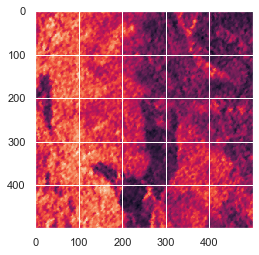

In [31]:
plt.imshow(data)

In [32]:
data

array([[ 1.2950095 ,  1.2944165 ,  1.2800831 , ..., -0.29757455,
        -0.29757455, -0.12937221],
       [ 1.2950095 ,  1.2944165 ,  1.2944165 , ..., -0.26795146,
        -0.29757455, -0.12937221],
       [ 1.47015   ,  1.2944165 ,  1.2944165 , ..., -0.26795146,
        -0.20284776, -0.20284776],
       ...,
       [ 1.397969  ,  1.397969  ,  1.4798021 , ...,  1.0758212 ,
         1.0758212 ,  1.2187028 ],
       [ 1.397969  ,  1.397969  ,  1.4798021 , ...,  1.2916387 ,
         1.2916387 ,  1.3531199 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.2916387 ,
         1.3531199 ,  1.3531199 ]], dtype=float32)

In [33]:
# inspecting geophysics files shape
for root, dirs, files in os.walk(path):
    for name in files:
        #print(os.path.join(root, name))
        ext = name.split('.')[-1]
        filename = name.split('.')[0]
        filepath = os.path.join(root, name)
        if ext == 'tif':
            openedfile = rasterio.open(filepath, 'r')
            filedata = openedfile.read(1)
            shape = filedata.shape
            print(f'the file {name} has the shape of {shape}')
            openedfile.close()

the file bouger_gravity_anomaly.tif has the shape of (500, 500)
the file isostatic_residual_gravity_anomaly.tif has the shape of (500, 500)
the file total_magnetic_intensity.tif has the shape of (500, 500)
the file variable_reduction_to_pole.tif has the shape of (500, 500)
the file filtered_potassium_pct.tif has the shape of (500, 500)
the file filtered_terrestrial_dose.tif has the shape of (500, 500)
the file filtered_thorium_ppm.tif has the shape of (500, 500)
the file filtered_uranium_ppm.tif has the shape of (500, 500)
the file aloh_groun_content.tif has the shape of (500, 500)
the file aloh_group_composition.tif has the shape of (500, 500)
the file ferric_oxide_content.tif has the shape of (500, 500)
the file ferrous_iron_content.tif has the shape of (500, 500)
the file ferrous_iron_index.tif has the shape of (500, 500)
the file kaolin_group_index.tif has the shape of (500, 500)
the file mgoh_group_content.tif has the shape of (500, 500)
the file opaque_index.tif has the shape of 

In [120]:
# create a dictionary to extract geophysics file features

file_structure = dict()

for root, dirs, files in os.walk(path):
    for name in files:
        #print(os.path.join(root, name))
        ext = name.split('.')[-1]
        filename = name.split('.')[0]
        filepath = os.path.join(root, name)
        if ext == 'tif':
            #print(f'the file {name} has the path{filepath}')
            filepath = filepath.replace('\\','/')
            first = '/'.join(filepath.split('/')[:5])
            second = '/'.join(filepath.split('/')[6:])
            file_structure[filename] = (first,second)
            #file_structure[filename] = (first,second)
            #print(f"... {os.path.join(first,'fileid',second)}")

In [121]:
file_structure

{'bouger_gravity_anomaly': ('/Users/mmsub/Module5/train',
  'geophysics/gravity/bouger_gravity_anomaly.tif'),
 'isostatic_residual_gravity_anomaly': ('/Users/mmsub/Module5/train',
  'geophysics/gravity/isostatic_residual_gravity_anomaly.tif'),
 'total_magnetic_intensity': ('/Users/mmsub/Module5/train',
  'geophysics/magnetics/total_magnetic_intensity.tif'),
 'variable_reduction_to_pole': ('/Users/mmsub/Module5/train',
  'geophysics/magnetics/variable_reduction_to_pole.tif'),
 'filtered_potassium_pct': ('/Users/mmsub/Module5/train',
  'geophysics/radiometrics/filtered_potassium_pct.tif'),
 'filtered_terrestrial_dose': ('/Users/mmsub/Module5/train',
  'geophysics/radiometrics/filtered_terrestrial_dose.tif'),
 'filtered_thorium_ppm': ('/Users/mmsub/Module5/train',
  'geophysics/radiometrics/filtered_thorium_ppm.tif'),
 'filtered_uranium_ppm': ('/Users/mmsub/Module5/train',
  'geophysics/radiometrics/filtered_uranium_ppm.tif'),
 'aloh_groun_content': ('/Users/mmsub/Module5/train',
  'remot

In [123]:
stamps_data= 'data/stamp_locations.geo.json'

In [124]:
stamps = gpd.read_file(stamps_data)

In [125]:
stamps[stamps['id']=='00014292']

,id,age,comment,commodities_string,original_id,latitude,longitude,name,offset_azimuth,offset_distance,rotation,centre_longitude,centre_latitude,local_projection,stratification_label,commodity_string,geometry
276,00014292,Archaean,nan,Au,333715.0,-28.452002,120.913028,Bannockburn,91.072937,4.498334,50.005914,120.959162,-28.457029,+proj=omerc +lat_0=-28.457028916885 +lonc=120....,Au,Au;Ni,"POLYGON ((121.13913 -28.44309, 120.97500 -28.6..."


In [126]:
stamps.age.value_counts()

Proterozoic            113
Archean                 98
Archaean                97
Palaeozoic              40
Precambrian             28
Tertiary                25
Palaeoproterozoic       24
Devonian                23
unknown                 22
Silurian                19
Quaternary              19
Permian                 15
Carboniferous           14
Late Ordovician         12
Cainozoic               11
Triassic                11
Early Devonian          10
Ordovician               9
Late Palaeozoic          8
Mesoproterozoic          7
Paleoproterozoic         5
Late Carboniferous       5
Early Cretaceous         5
Early Permian            4
Late Cambrian            4
Early Palaeozoic         4
Late Triassic            4
Neoproterozoic           4
Late Permian             4
Cambrian                 3
Late Silurian            3
Early Pliocene           3
Cretaceous               3
Middle Devonian          2
Pleistocene              2
Early Ordovician         1
Paleogene                1
M

In [127]:
stamps.groupby(['stratification_label','age'])['stratification_label'].count()

stratification_label  age          
Au                    Archaean         58
                      Archean          85
                      Cainozoic         5
                      Cambrian          1
                      Carboniferous     8
                                       ..
other                 Proterozoic       5
                      Quaternary       18
                      Silurian          1
                      Tertiary          8
                      Triassic          1
Name: stratification_label, Length: 107, dtype: int64

In [128]:
stamps.shape

(2485, 17)

In [129]:
trainpath = '/Users/mmsub/Module5/train'

In [130]:
id_label = dict()

for i, label in zip(stamps['id'].tolist(),stamps['stratification_label'].tolist()):
    id_label[i] = label

In [131]:
trainids = os.listdir(trainpath)

In [132]:
len(trainids)

1863

In [133]:
# fixing stamp that does not have trainset
id_train = dict()

for item in trainids:
    label = id_label.get(item)
    if label == None:
        id_train[item] = 'none'
    else:
        id_train[item] = label

In [135]:
# extract feature stats

for key, value in file_structure.items():
    print(f'processing...{key}')
    name = ''.join(key.split('_')[:2])
    print(name)
    df_data = defaultdict(list)
    
    for i, stampid in enumerate(trainids):
        label = id_train[stampid]
        df_data['id'].append(stampid)
        df_data['label'].append(label)
        first, second = value
        image_path = os.path.join(first,stampid,second)
        #print(image_path)
        try:
            with rasterio.open(image_path, 'r') as src:
                image_data = src.read()
                _max = image_data.max()
                _min = image_data.min()
                _mean = image_data.mean()
                df_data['_max'].append(_max)
                df_data['_min'].append(_min)
                df_data['_mean'].append(_mean)
        except Exception as err:
            print(err)
            continue
            
        if i%500 == 0:
                print(f'{i}/{len(trainids)} images processed')
    print(f'{i+1}/{len(trainids)} images processed')
    df = pd.DataFrame(df_data)
    print(f'saving... csv {name}_.csv')
    df.to_csv(f'{name}_.csv',index=False)

processing...bouger_gravity_anomaly
bougergravity
0/1863 images processed
500/1863 images processed
1000/1863 images processed
1500/1863 images processed
1863/1863 images processed
saving... csv bougergravity_.csv
processing...isostatic_residual_gravity_anomaly
isostaticresidual
0/1863 images processed
500/1863 images processed
1000/1863 images processed
1500/1863 images processed
1863/1863 images processed
saving... csv isostaticresidual_.csv
processing...total_magnetic_intensity
totalmagnetic
0/1863 images processed
500/1863 images processed
1000/1863 images processed
1500/1863 images processed
1863/1863 images processed
saving... csv totalmagnetic_.csv
processing...variable_reduction_to_pole
variablereduction
0/1863 images processed
500/1863 images processed
1000/1863 images processed
1500/1863 images processed
1863/1863 images processed
saving... csv variablereduction_.csv
processing...filtered_potassium_pct
filteredpotassium
0/1863 images processed
500/1863 images processed
1000/1